In [1]:
import os
import pandas as pd
import numpy as np

from nltk.tokenize import sent_tokenize

# Read and Prepare DataFrame

In [2]:
eng_reviews_df = pd.read_json("preprocessed_english_reviews.json")
eng_reviews_df.tail(1)

,comments,comments_cleaned,comments_l,comments_token,comments_token_str,date,id,index,language,listing_id,probability,review_length,reviewer_id,reviewer_name,sentence_length
362299,The host canceled this reservation 4 days befo...,host canceled reservation days arrival automat...,the host canceled this reservation 4 days befo...,"[host, cancel, reserv, day, arriv, autom, post]",host cancel reserv day arriv autom post,2019-05-04,447965634,452636,en,34384353,0.958796,87,49082420,Maxime,14


## Remove all Airbnb automated postings for host cancellations

When a host cancels a reservation, Airbnb automatically posts on host's page as a 'penalty'
These messages should be removed as they are not actual reviews written by guests, do not reflect on their experience hence would cloud text summarisations produced.

In [3]:
eng_reviews_df = eng_reviews_df[~eng_reviews_df.comments.str.contains("The host canceled this reservation")]

## Tokenise comments into sentences

Textrank and Extractive method both analyse each sentence in a comment seperately, give each weights to determine their importance in the entire comment.

In [4]:
example = "Hello! Hello world. Hello worrlddd?"
sent_tokenize(example)

['Hello!', 'Hello world.', 'Hello worrlddd?']

In [5]:
eng_reviews_df['sentences'] = eng_reviews_df['comments'].apply(lambda x: sent_tokenize(x))

## Clean sentences

In [6]:
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')

from datajanitor.text import create_ngram, remove_stopword, symbols_replaced, decontracted, remove_html_tags, split_words_and_punctuation, apply_text_normalisation
from utils import keep_token_pattern, chain

operations = [{"function": symbols_replaced},
              {"function": decontracted},
              {"function": remove_html_tags},
              {"function": split_words_and_punctuation},
              {"function": remove_stopword, "stopword_list": english_stop_words},
              {"function": keep_token_pattern, "pattern": '[a-zA-Z]{3,}'}
             ]

In [7]:
eng_reviews_df['sentences_cleaned'] = eng_reviews_df['sentences'].apply(lambda x: [chain(sentence.lower(), operations) for sentence in x])

## Normalise sentences

In [8]:
from nltk.stem.snowball import SnowballStemmer

sb = SnowballStemmer("english").stem

In [9]:
eng_reviews_df['sentences_normalised'] = eng_reviews_df['sentences_cleaned'].apply(lambda x: [apply_text_normalisation(sentence, sb) for sentence in x])

In [12]:
eng_reviews_df.to_json("preprocessed_english_reviews_in_setences.json", orient='records')

In [2]:
eng_reviews_df = pd.read_json("preprocessed_english_reviews_in_setences.json")

## Get sample listing

Used as example for text summarisation

In [3]:
grouped_eng_reviews = eng_reviews_df.groupby('listing_id')
listing_2818 = grouped_eng_reviews.get_group(2818)

In [4]:
all_review_sentences = listing_2818['sentences_cleaned']
flatten_review_sentences = [sentence for review in all_review_sentences for sentence in review]
flatten_review_sentences[0]

['daniel', 'really', 'cool']

In [5]:
all_review_sentences_norm = listing_2818['sentences_normalised']
flatten_review_sentences_norm = [sentence for review in all_review_sentences_norm for sentence in review]
flatten_review_sentences_norm[0]

['daniel', 'realli', 'cool']

## Prepare GloVe for word embedding

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2019-06-27 20:33:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-06-27 20:33:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-06-27 20:33:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [17]:
def extract_word_vector(vector_path):
    word_embeddings = {}
    with open(vector_path, "r", encoding='utf-8') as vector_file:
        for line in vector_file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = coefs
    return word_embeddings

In [70]:
dims = 100
word_embeddings = extract_word_vector(f"./glove.6B.{dims}d.txt")

In [7]:
import pickle

# with open(f'glove_embeddings_{dims}.pkl', 'wb') as pklfile:
#     pickle.dump(word_embeddings, pklfile)
dims = 100
with open(f'glove_embeddings_{dims}.pkl', 'rb') as pklfile:
    word_embeddings = pickle.load(pklfile)

The GloVe word embeddings contains 400K different terms. 
GloVe contains 4 different dimension vectors - 50d, 100d, 200d & 300d.
The difference relates to how much information from 400K terms are squeezed into each dimension vector.

# Text summarisation

## TextRank

In [ ]:
# https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70

In [8]:
import itertools

from nltk.cluster.util import cosine_distance
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [9]:
def sentence_similarity(vector1, vector2):
    similarity_score = 1 - cosine_distance(vector1, vector2)

    if np.isnan(similarity_score):
        similarity_score = 0

    return similarity_score

In [10]:
import scipy

def build_similarity_matrix(sentence_vectors, verbose=False):
    sentence_length = sentence_vectors.shape[0]

    if isinstance(sentence_vectors, scipy.sparse.csr.csr_matrix):
        sentence_vector_arrays = sentence_vectors.toarray()
    else:
        sentence_vector_arrays = sentence_vectors

    # Create an empty similarity matrix
    similarity_matrix = np.zeros((sentence_length, sentence_length))

    # create index of word pairs
    permutation_set = list(itertools.permutations(range(0, sentence_length), 2))

    for pair in permutation_set:
        idx1, idx2 = pair

        sent1 = sentence_vector_arrays[idx1]
        sent2 = sentence_vector_arrays[idx2]

        if verbose:
            print(f"Sentences: \n{sent1}\n{sent2}")

        similarity_matrix[idx1][idx2] = sentence_similarity(sentence_vector_arrays[idx1], sentence_vector_arrays[idx2])

    return similarity_matrix

In [11]:
def visualise_top_scores(scores, flatten_sentences, n_top):
    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i], s) for i, s in enumerate(flatten_sentences)), reverse=True)    

    summarize_text = []

    for i in range(n_top):
#         summarize_text.append(" ".join(ranked_sentence[i][1]))
        summarize_text.append(ranked_sentence[i][1])
    return summarize_text

In [12]:
top_n = 5

### Using Simple Word Count

In [33]:
def dummy_fun(token):
    return token

textrank_count_vectorizer = CountVectorizer(
                        strip_accents='unicode',
                        preprocessor=dummy_fun,
                        analyzer=dummy_fun,
                        max_features = 5000)

textrank_count_vectorizer.fit(eng_reviews_df['comments_token'])

CountVectorizer(analyzer=<function dummy_fun at 0x1a7f51f510>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=5000, min_df=1, ngram_range=(1, 1),
        preprocessor=<function dummy_fun at 0x1a7f51f510>, stop_words=None,
        strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [56]:
sentence_vectors = textrank_count_vectorizer.transform(flatten_review_sentences_norm)
similarity_matrix_countvec = build_similarity_matrix(sentence_vectors)

/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [57]:
sentence_similarity_graph_countvec = nx.from_numpy_array(similarity_matrix_countvec)
countvec_scores = nx.pagerank(sentence_similarity_graph_countvec)

In [58]:
visualise_top_scores(countvec_scores, flatten_review_sentences, n_top=top_n)

['traveled first time amsterdam friend stayed daniel excelent host helping find routes gave lots tips handle things amsterdam place clean quiet recomment daniel room',
 'grear stay daniel',
 'staying daniel great',
 'great stay daniel',
 'daniel place great daniel wad easy going helpful']

### Using Tfidf

In [62]:
textrank_tfidf_vectorizer = TfidfVectorizer(
                        strip_accents='unicode',
                        preprocessor=dummy_fun,
                        analyzer='word',
                        ngram_range=(1, 1),
                        min_df=10,    
                        use_idf=True, smooth_idf=True, 
                        max_features = 5000)

textrank_tfidf_vectorizer.fit(eng_reviews_df['comments_token_str'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=10,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function dummy_fun at 0x1a7f51f510>, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [63]:
flatten_review_sentences_joined = [" ".join(sentence) for sentence in flatten_review_sentences_norm]
sentence_vectors_tfidf = textrank_tfidf_vectorizer.transform(flatten_review_sentences_joined)
similarity_matrix_tfidf = build_similarity_matrix(sentence_vectors_tfidf)

/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [64]:
sentence_similarity_graph_tfidf = nx.from_numpy_array(similarity_matrix_tfidf)
tfidf_scores = nx.pagerank(sentence_similarity_graph_tfidf)

In [68]:
visualise_top_scores(tfidf_scores, flatten_review_sentences, top_n)

['would recommend staying daniel',
 'staying daniel great',
 'great stay daniel',
 'staying daniel apartment great',
 'grear stay daniel']

### Using GloVe Embeddings

Wikipedia 2014 + Gigaword 5
https://nlp.stanford.edu/projects/glove/
Word
embeddings are substantially successful in capturing semantic
relations among words,
The Euclidean distance (or cosine similarity) between two word vectors provides an effective method for measuring the linguistic or semantic similarity of the corresponding words

In [13]:
def get_sentence_vector(word_embeddings, sentence, we_dim):
    vector = np.zeros((we_dim, ))

    sentence_length = len(sentence) + 0.001

    if sentence:
        sentence_embeddings = sum([word_embeddings.get(word, vector) for word in sentence])

        vector = sentence_embeddings/sentence_length

    return vector

In [14]:
flatten_reviews_for_vis = [sentence for sentences in listing_2818['sentences'].tolist() for sentence in sentences]

sentence_embedding_vectors = []

for review_sentence in flatten_review_sentences:
    sentence_vector = get_sentence_vector(word_embeddings, review_sentence, dims)
    sentence_embedding_vectors.append(sentence_vector)

In [15]:
glove_similarity_matrix = build_similarity_matrix(np.array(sentence_embedding_vectors))
glove_sentence_similarity_graph = nx.from_numpy_array(glove_similarity_matrix)
glove_scores = nx.pagerank(glove_sentence_similarity_graph)

/Users/fionachow/anaconda3/envs/dcuration/lib/python3.6/site-packages/nltk/cluster/util.py:133: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [16]:
visualise_top_scores(scores=glove_scores, flatten_sentences=flatten_reviews_for_vis, n_top=top_n)

['HOST: Daniel was very accomodating, has prepared everything you will need for your stay in the city, you get to have great and fun conversations with him, you will be for sure well taken care of!',
 "Not only was the room comfortable, colourful, light, quiet, and equipped with everything we could possibly need - and Daniel's flat spotless and beautifully furnished and in a great location - but Daniel himself is the perfect host, spending the first hour of our arrival talking to us about Amsterdam, answering our many questions, showing us how to get around.",
 'He was friendly, extremely helpful & went the extra mile to make sure my friend and I were at home at his place.',
 'His attention to details and kindness make his place an excellent alternative for those considering a bed and breakfast in Amsterdam\r\nI strongly advise to consider his place: Great location, an affordable price, a clean and organized room and a great host.',
 'I traveled first time to Amsterdam with a friend an

In [92]:
listing_2818[listing_2818.comments.str.contains("fun conver")]['comments'].tolist()

["ROOM: cozy and comfortable, a calming beautiful window view of a garden.\nAPARTMENT: beautiful interior & relaxing, feels like home!\nNEIGHBORHOOD: quiet and pleasant, a bit away from the city center but you get to visit lots of cafe's and restaurant around aswell.\nHOST: Daniel was very accomodating, has prepared everything you will need for your stay in the city, you get to have great and fun conversations with him, you will be for sure well taken care of! A great person, so far the best experience I had having a such a host! Thank you again!!!"]

## Extractive Method

### Using Tfidf

https://blog.floydhub.com/gentle-introduction-to-text-summarization-in-machine-learning/

In [81]:
listing_2818_review_weights = [textrank_tfidf_vectorizer.transform(sentence).sum(axis=0) if sentence else np.array(0) for sentence in flatten_review_sentences]
listing_2818_sentence_weights = np.array([w.sum() for w in listing_2818_review_weights])

### Weightage bias towards length of sentence?

In [82]:
listing_2818_review_lengths = [len(review_sentence) if len(review_sentence) else 0.01 for review_sentence in flatten_review_sentences]
length_weight = list(zip(listing_2818_review_lengths, listing_2818_sentence_weights))
len(listing_2818_review_lengths), len(listing_2818_sentence_weights), len(length_weight)

(1122, 1122, 1122)

In [83]:
sorted_length_weight = sorted(length_weight, key=lambda tup:tup[0], reverse=True)

print("Longest:\n")
print(sorted_length_weight[:5])
print("Shortest:\n")
print(sorted_length_weight[-5:])

Longest:

[(32, 18.0), (32, 17.0), (27, 15.0), (24, 13.0), (24, 14.0)]
Shortest:

[(0.01, 0.0), (0.01, 0.0), (0.01, 0.0), (0.01, 0.0), (0.01, 0.0)]


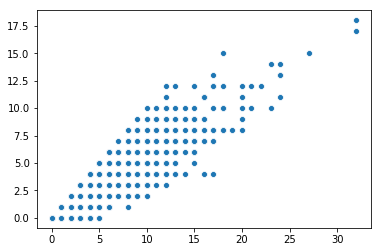

In [84]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

seaborn.scatterplot(x=listing_2818_review_lengths, y=listing_2818_sentence_weights)

In [85]:
average_weights = [x/y for x,y in zip(listing_2818_sentence_weights, listing_2818_review_lengths)]

In [86]:
sorted_av_length_weight = sorted(list(zip(listing_2818_review_lengths,average_weights)) , key=lambda tup:tup[0], reverse=True)

print("Longest:\n")
print(sorted_av_length_weight[:5])
print("Shortest:\n")
print(sorted_av_length_weight[-5:])

Longest:

[(32, 0.5625), (32, 0.53125), (27, 0.5555555555555556), (24, 0.5416666666666666), (24, 0.5833333333333334)]
Shortest:

[(0.01, 0.0), (0.01, 0.0), (0.01, 0.0), (0.01, 0.0), (0.01, 0.0)]


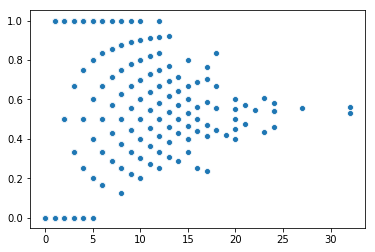

In [87]:
seaborn.scatterplot(x=listing_2818_review_lengths, y=average_weights)

In [89]:
top_sentences_pos_listing_2818 = np.array(average_weights).argsort()[-1*top_n:][::-1]
top_listing_2818_sentences = np.array(flatten_review_sentences)[top_sentences_pos_listing_2818]
[" ".join(top_sentence) for top_sentence in top_listing_2818_sentences]

['hope rebook stay later year',
 'daniel great host',
 'nice host',
 'feel safe comfort daniel place',
 'come enjoy']

In [102]:
def get_listing_summary(listing_df, count_vectorizer, top_n_sentence=3):
    """
    """
    listing_review = np.array([review_sentence for review_sentences in listing_df['sentences_cleaned'].tolist() for review_sentence in review_sentences])
    listing_review_norm = np.array([review_sentence for review_sentences in listing_df['sentences_normalised'].tolist() for review_sentence in review_sentences])

    # get sentence weights
    listing_review_weights = [count_vectorizer.transform(sentence).sum(axis=0) if sentence else np.array(0) for sentence in listing_review_norm]
    listing_sentence_weights = np.array([w.sum() for w in listing_review_weights])

    # to ensure long sentences do not have unnecessarily high scores over short sentences
    # we divided each score of a sentence by the number of words found in that sentence.
    # to avoid ZeroDivisionError, added 0.01 to empty lists
    listing_review_lengths = [len(review_sentence) if len(review_sentence) else 0.01 for review_sentence in listing_review]
    average_weights = [weight/length for weight, length in zip(listing_sentence_weights, listing_review_lengths)]

    # projected cleaned but unnormalised version of top sentences
    top_sentences_pos = listing_sentence_weights.argsort()[-1*top_n_sentence:][::-1]
    top_sentences = [" ".join(sentence) for sentence in np.array(listing_review)[top_sentences_pos]]

    return top_sentences

In [103]:
listing_df = grouped_eng_reviews.get_group(82482)
get_listing_summary(listing_df, count_vectorizer)

['friendly host family amazing appartement amsterdam next visit would definitely like live supermarket next door open lots pubs caf restaurants cash machine min walk leidsplein aawww airport wifi ofcourse stereo equipment left headphone connector cable plug ipod iphone whatever',
 'loved stay shawna flat lightfull better put eyes cover clean website hidden airbnb central next grocery shops kind website hidden airbnb nice family let make reservation van gogh museum make cue',
 'nice room negative thing roof light made hard sleep wasnt dark witch two younger children hot sun came really small bathroom hard help kids shower small shower']

## Abstractive Method